Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12845075896304996761
xla_global_id: -1
]
Compiling model...
Building feed-forward neural network...


C:\Users\yesda\AppData\Local\Temp\ipykernel_33924\587982116.py:47: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l*360/2*np.pi), 0, l)
C:\Users\yesda\AppData\Local\Temp\ipykernel_33924\587982116.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l*360/2*np.pi), 0, l)
c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future ver


'build' took 0.220788 s


'compile' took 0.572173 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.42e-04, 5.79e+01]    [3.79e-04, 5.79e+01]    [9.86e-01]    
1000      [8.48e-03, 2.41e+01]    [7.73e-02, 2.41e+01]    [9.76e-01]    
2000      [3.09e-03, 2.40e+01]    [5.28e-02, 2.40e+01]    [9.76e-01]    
3000      [6.18e-04, 2.39e+01]    [3.24e-02, 2.39e+01]    [9.75e-01]    
4000      [9.91e-03, 2.34e+01]    [2.60e-02, 2.34e+01]    [9.74e-01]    
5000      [1.13e-01, 2.08e+01]    [1.10e-01, 2.08e+01]    [9.66e-01]    
6000      [1.26e-02, 2.08e+00]    [2.48e-02, 2.08e+00]    [8.46e-01]    
7000      [1.37e-04, 3.02e-03]    [6.88e-03, 3.02e-03]    [8.33e-01]    
8000      [1.46e-04, 1.00e-03]    [6.58e-03, 1.00e-03]    [8.33e-01]    
9000      [1.21e-04, 6.59e-04]    [9.18e-03, 6.59e-04]    [8.33e-01]    
10000     [7.47e-05, 5.04e-04]    [1.34e-02, 5.04e-04]    [8.33e-01]    
11000     [5.14e-05, 4.16e-04]    [1.67e-02, 4.16e-

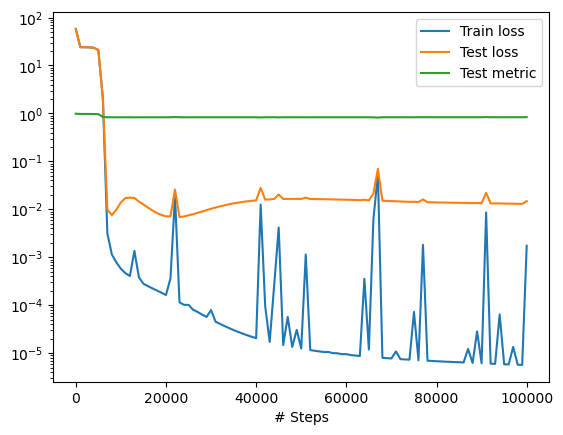

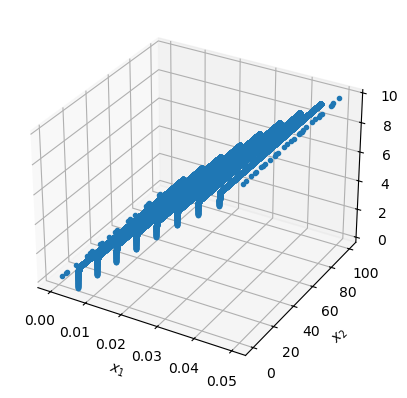

In [1]:
#Change the pde in degree
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TensorFlow v1 compatibility
tf.compat.v1.disable_eager_execution()

# Set TensorFlow to use all available cores
num_cores = 20
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores,allow_soft_placement=True,device_count={'CPU': num_cores})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# List available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


D = 3.8e-11 #m^2/s
C0 = 0.0 #moles/m^3
C1 = 10 #moles/m^3
l = 0.05 #m
t = 1e2 #s

def pde(x, y):
   
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (dy_t- D*dy_xx)

def f(x):
     return 1
  
def func(x):
    n_terms = 25  # Number of terms in the series to approximate the solution
    result = C0 + (x[:, 0:1] / l) * (C1 - C0)
    for n in range(1, n_terms + 1):
        from scipy.integrate import quad
        integral, _ = quad(lambda x: f(x) * np.sin(n * np.pi * x/ l*360/2*np.pi), 0, l)
        cn = (2 / l) * integral + (2 / (n * np.pi)) * ((-1)**n * (C1 - C0))  
        term = cn * np.exp(-n**2 * np.pi**2 * D * x[:, 1:2] / l**2) * np.sin(n * np.pi * x[:, 0:1] / l*360/2*np.pi)
        result += term
    return result

geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1]/ l) * 10, lambda _, on_boundary: on_boundary)
#ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)
#ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
#observe_x1 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 10000))).T
#observe_y1 = dde.icbc.PointSetBC(observe_x1, func(observe_x1), component=0)
#observe_x2 = np.vstack((np.linspace(0.02, 0.04, num=5), np.full((5), 500))).T
#observe_y2 = dde.icbc.PointSetBC(observe_x2, func(observe_x2), component=0)

data = dde.data.TimePDE(geomtime, pde, [bc], num_domain=50, solution=func, num_boundary=50, num_test=100000)
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


model = dde.Model(data, net)
model.compile("adam", lr=0.0001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=100000)

#early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
#losshistory, train_state = model.train(iterations=100, callbacks=[early_stopping])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)



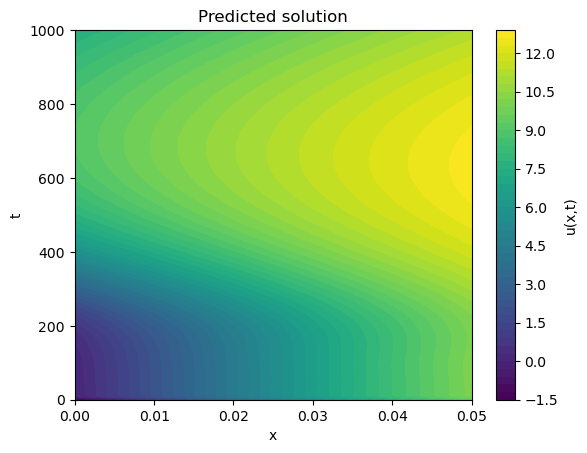

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


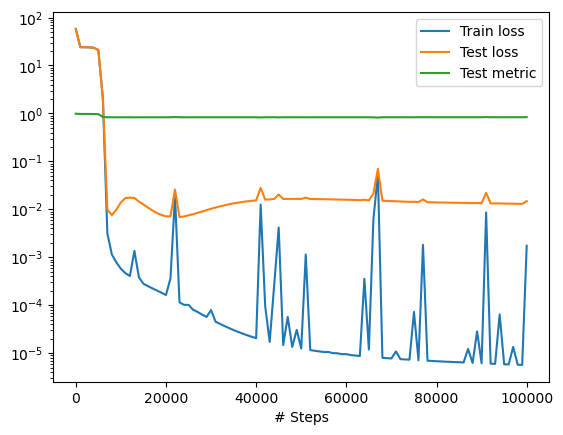

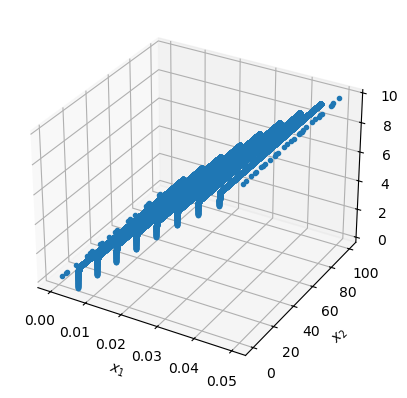

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 1000,100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

# Save the plot and loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
